# Chapter 09: Working with Unstructured Data

In today's data-driven world, companies are inundated with vast amounts of unstructured data, including documents, slides, emails, and more. Transforming this unstructured data into structured formats is crucial for unlocking its full potential. Leveraging LLMs enables businesses to efficiently convert unstructured information into datasets that can be stored in databases, CSV files, and other structured formats. This transformation not only facilitates data management but also allows for the training of machine learning models on the structured datasets. Ultimately, structured data can be seamlessly integrated into various workflows, functions, and processes, enabling more informed decision-making across the organization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from pathlib import Path
from pydantic import BaseModel, Field
from sklearn.metrics import accuracy_score
from language_models.models.llm import OpenAILanguageModel
from language_models.agent import (
    Agent,
    Workflow,
    WorkflowLLMStep,
    OutputType,
    PromptingStrategy,
)
from language_models.proxy_client import ProxyClient
from language_models.settings import settings

In [2]:
proxy_client = ProxyClient(
    client_id=settings.CLIENT_ID,
    client_secret=settings.CLIENT_SECRET,
    auth_url=settings.AUTH_URL,
    api_base=settings.API_BASE,
)

## Sentiment Analysis

For sentiment analysis of tweets, we can automate the process using an LLM to classify sentiment and store its reasoning. Instead of a chat-based application where users manually input tweets, the LLM can analyze tweets in bulk, classify sentiment, and record reasoning. Additionally, the LLM can extract properties such as tagged users and hashtags.

In [3]:
df_tweets = pd.read_csv("./assets/datasets/tweets.csv.gz", compression="gzip", encoding="latin-1", names=["sentiment", "id", "date", "query", "user", "tweet"])
df_tweets = df_tweets.dropna()
df_tweets = df_tweets.where(df_tweets.sentiment != 2)
df_tweets["sentiment"] = df_tweets["sentiment"].map({4: 1, 0: 0})
df_tweets_sampled = df_tweets.sample(20)
df_tweets_sampled.head()

,sentiment,id,date,query,user,tweet
671309,0,2246825818,Fri Jun 19 18:10:52 PDT 2009,NO_QUERY,islandiva147,@rvj5234 I can't believe my shows are over. De...
1354048,1,2046913677,Fri Jun 05 12:52:40 PDT 2009,NO_QUERY,flukux,@theryrf Hey Natt.. yes i saw papa.. I invited...
504607,0,2188173312,Mon Jun 15 21:25:36 PDT 2009,NO_QUERY,flightime,@unbeauxorage because i get the feeling that y...
158157,0,1956545621,Thu May 28 22:06:46 PDT 2009,NO_QUERY,jkg_vader,@Maudelynn I'd totally initiate hanging out w...
1376111,1,2051705947,Fri Jun 05 22:36:28 PDT 2009,NO_QUERY,ijPerez,So in overall my night consisted mostly of me ...


In [4]:
system_prompt = """Take the following tweet and determine the sentiment of the review.

Respond with 1 (positive) or 0 (negative).

If you don't receive a tweet, respond with -1.

Additionally, provide the reason for your choice and extract all tagged users."""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=250,
    temperature=0.2,
)

class Tweet(BaseModel):
    sentiment: int = Field(description="The sentiment of the tweet")
    reason: str = Field(description="The reason why you chose the sentiment")
    tagged: list[str] = Field(description="A list of people that are tagged, e.g. @user")

sentiment_analysis_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{tweet}",
    prompt_variables=["tweet"],
    output_type=OutputType.OBJECT,
    output_schema=Tweet,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [5]:
def classify_sentiment(row) -> pd.Series:
    output = sentiment_analysis_agent.invoke({"tweet": row.tweet})
    sentiment = output.final_answer.sentiment or 0
    reason = output.final_answer.reason or ""
    tagged = output.final_answer.tagged or []
    sentiment_analysis_agent.chat.reset()
    return pd.Series([sentiment, reason, tagged], index=["prediction", "reason", "tagged"])

In [6]:
df_tweets_sampled[["prediction", "reason", "tagged"]] = df_tweets_sampled.apply(classify_sentiment, axis=1)

Final Answer: sentiment=0 reason='The user expresses sadness and depression due to their shows being over.' tagged=['@rvj5234']
Final Answer: sentiment=1 reason="The user mentioned a positive experience of inviting someone for dinner and described it as 'very nice'." tagged=['@theryrf']
Final Answer: sentiment=1 reason="The tweet is positive because the user is expressing concern about someone else's feelings and doesn't want them to feel ignored." tagged=['@unbeauxorage']
Final Answer: sentiment=1 reason='The tweet is expressing a positive sentiment towards the user @Maudelynn, stating they would like to hang out with them and that they think they are awesome.' tagged=['@Maudelynn']
Final Answer: sentiment=1 reason='The user seems to be expressing a positive sentiment as they enjoyed their night playing a game and winning.' tagged=['@nawrm']
Final Answer: sentiment=1 reason="The tweet is neutral or positive as it uses a common, friendly phrase 'peace out'." tagged=['@KatrinaSidonia']


In [7]:
df_tweets_sampled.head(20)

,sentiment,id,date,query,user,tweet,prediction,reason,tagged
671309,0,2246825818,Fri Jun 19 18:10:52 PDT 2009,NO_QUERY,islandiva147,@rvj5234 I can't believe my shows are over. De...,0,The user expresses sadness and depression due ...,[@rvj5234]
1354048,1,2046913677,Fri Jun 05 12:52:40 PDT 2009,NO_QUERY,flukux,@theryrf Hey Natt.. yes i saw papa.. I invited...,1,The user mentioned a positive experience of in...,[@theryrf]
504607,0,2188173312,Mon Jun 15 21:25:36 PDT 2009,NO_QUERY,flightime,@unbeauxorage because i get the feeling that y...,1,The tweet is positive because the user is expr...,[@unbeauxorage]
158157,0,1956545621,Thu May 28 22:06:46 PDT 2009,NO_QUERY,jkg_vader,@Maudelynn I'd totally initiate hanging out w...,1,The tweet is expressing a positive sentiment t...,[@Maudelynn]
1376111,1,2051705947,Fri Jun 05 22:36:28 PDT 2009,NO_QUERY,ijPerez,So in overall my night consisted mostly of me ...,1,The user seems to be expressing a positive sen...,[@nawrm]
212506,0,1974755541,Sat May 30 13:46:50 PDT 2009,NO_QUERY,BiancaArevalo,@KatrinaSidonia peace out,1,The tweet is neutral or positive as it uses a ...,[@KatrinaSidonia]
236917,0,1980097259,Sun May 31 05:40:32 PDT 2009,NO_QUERY,unknownshortkid,just got home from driving around the bay and ...,1,The tweet expresses a positive experience of d...,[]
687253,0,2251225198,Sat Jun 20 02:49:55 PDT 2009,NO_QUERY,Nisha_L,@Gurlstrange I haven't had runny nose for a LO...,0,The user is discussing a negative experience w...,[@Gurlstrange]
1398507,1,2054111797,Sat Jun 06 06:35:12 PDT 2009,NO_QUERY,RosalieCullen,@BenjaminReid I really like that picture!!!,1,The user expressed a positive sentiment toward...,[@BenjaminReid]
1251887,1,1996596806,Mon Jun 01 15:21:16 PDT 2009,NO_QUERY,Bex23007,@Tyrese4ReaL u were damn funny on the MTV awar...,1,The tweet is complimenting the user for being ...,[@Tyrese4ReaL]


In [8]:
print(f"Accuracy: {accuracy_score(df_tweets_sampled.sentiment, df_tweets_sampled.prediction)}")

Accuracy: 0.65


## Drafting Contracts

When it comes to using LLMs to draft contracts, it's important to consider that contracts are often lengthy documents, sometimes spanning over 100 pages. This renders conversation-based applications impractical, as LLMs cannot generate such extensive documents, and users prefer not to interact directly with the LLM and manage its outputs themselves.

Here's a potential approach for an application to draft contracts: Rather than expecting the LLM to generate the entire document at once, we can break it down into manageable sections. Users could provide bullet points for each section, allowing the LLM to formulate the corresponding paragraphs and suggest a title for each section. The application would then concatenate these outputs to create a document. Additionally, in practical scenarios, it's likely necessary to grant the LLM access to specific laws or legal references in some manner.

In [9]:
system_prompt = """Your primary task is to draft very detailed sections of contracts, ensuring they align with regulations.

Only write about the section name you will receive and do not write any information outside of that."""

prompt = """Overall goal: {goal}

Section name: {section}
Consider this context:
{context}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=4000,
    temperature=0.2,
)

draft_contract_section = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["goal", "section", "context"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [10]:
system_prompt = """You are tasked with refining contract sections.

Where regulations are applied, include the references."""

prompt = """Overall goal: {goal}

Section name: {section}
Draft:
{draft}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4-32k',
    max_tokens=4000,
    temperature=0.2,
)

refine_contract_section = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["goal", "section", "draft"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [11]:
class Inputs(BaseModel):
    goal: str = Field(description="The contract the user wants to draft")
    section: str = Field(description="The title section")
    context: str = Field(description="The context provided for a section as bullet points")

workflow = Workflow(
    name="Generates a contract section",
    description="Uses LLMs to generate a contract section given some context",
    inputs=Inputs,
    output="refine",
    steps=[
        WorkflowLLMStep(name="draft", agent=draft_contract_section),
        WorkflowLLMStep(name="refine", agent=refine_contract_section),
    ]
)

In [12]:
goal = """Draft a contract for the development, procurement, and maintenance of weapons systems,
namely unmanned aerial vehicles, between ABC Inc (referred to as employee)
and XYZ referred to as employer. Provide information about the background,
Applicable Documents, Requirements, Security."""

class ContractSection(BaseModel):
    title: str
    context: str

scope_of_work = ContractSection(
    title="Scope of Work",
    context="""The Contractor shall provide all personnel, equipment, materials, and facilities necessary to design, develop, manufacture, test, deliver, and maintain the UAV systems.

The scope includes:
- Design & Development:
- Procurement & Manufacturing:
- Maintenance & Support:
- Training & Documentation:""",
)

technical_requirements = ContractSection(
    title="Technical Requirements",
    context="""The technical requirements should include:
- Design Specifications:
- Software Development:
- System Integration:""",
)

delivery_requirements = ContractSection(
    title="Delivery Requirements",
    context="""The delivery requirements should include:
- Production Schedule:
- Quality Assurance:""",
)

maintenance_requirements = ContractSection(
    title="Maintenance Requirements",
    context="""The maintenance requirements should include:
- Maintenance Services:
- Spare Parts:""",
)

security_requirements = ContractSection(
    title="Security Requirements",
    context="""Compliance with cybersecurity and protection plans, etc.

The security requirements should include:
- Security Classification:
- Facility Security:""",
)

cybersecurity_requirements = ContractSection(
    title="Cybersecurity Requirements",
    context="""Compliance with cybersecurity and protection plans, etc.

The cybersecurity requirements should include:
- Incident Reporting:""",
)

period_of_performance = ContractSection(
    title="Period of Performance",
    context="""This section should include:
- Start and End Dates: Clearly specify the contract start date (e.g., "Commencement of work on [Start Date]") and the expected completion date (e.g., "Completion of all contractual obligations by [End Date]"), ensuring alignment with project milestones and deliverables.
- Milestone Deadlines: Outline critical milestone dates within the period of performance, including deadlines for design reviews, prototype delivery, testing phases, and final system delivery, to ensure progress is tracked and managed effectively.
- Options for Extension: Include provisions for possible extensions or modifications of the period of performance, detailing the process and conditions under which the contract duration may be extended (e.g., unforeseen delays, additional work requirements).""",
)

payment_and_funding = ContractSection(
    title="Payment and Funding",
    context="""This section should include:
- Contract Value:
- Payment Schedule:
- Funding Obligations:""",
)

contract_administration = ContractSection(
    title="Contract Administration",
    context="""This section should include:
- Contracting Officer Responsibilities: Identify the designated Contracting Officer (CO) from the employer, outlining their authority to administer the contract, make decisions, issue modifications, and handle any formal communications between the employer and the Contractor.
- Contractor Point of Contact: Specify the primary point of contact (POC) from ABC Inc., responsible for managing contract performance, responding to CO inquiries, and ensuring timely submission of required deliverables and reports.
- Record-Keeping and Reporting Requirements: Detail the procedures for maintaining and submitting records related to contract performance, including regular status reports, financial documentation, and compliance records, ensuring they meet the standards set by applicable regulations."""
)

disputes = ContractSection(
    title="Disputes",
    context="""This section should include:
- Dispute Resolution Process: Outline the step-by-step process for resolving disputes, including initial negotiation efforts, escalation procedures, and potential use of alternative dispute resolution (ADR) methods like mediation or arbitration before resorting to litigation.
- Governing Law and Jurisdiction: Specify the applicable law governing the contract (e.g., the law of the country or region) and the jurisdiction or venue where disputes will be adjudicated.
- Timelines for Filing Claims: Define the timeframes within which disputes must be raised and resolved, including deadlines for filing formal claims, submitting responses, and completing the dispute resolution process to prevent delays in contract performance."""
)

termination = ContractSection(
    title="Termination",
    context="""This section should include:
- Termination for Convenience: Specify the conditions under which either party may terminate the contract for convenience, including the required notice period (e.g., 30 days) and any obligations for settling outstanding payments and deliverables upon termination.
- Termination for Cause: Outline the circumstances that allow termination for cause, such as failure to perform contractual obligations, non-compliance with terms, or breach of contract. Include the procedures for notifying the offending party, providing opportunities to cure breaches, and the process for formal termination.
- Settlement of Accounts: Detail the procedures for the settlement of accounts upon termination, including the return of any employer-furnished property, final payments for work performed up to the termination date, and any adjustments for partially completed work or costs incurred."""
)

signatures = ContractSection(
    title="Signatures",
    context="""This section should include:
- Authorized Signatures: Ensure that the contract is signed by authorized representatives from both XYZ and ABC Inc., including the names, titles, and dates of signing, along with any required witness signatures."""
)

contract_sections = [
    scope_of_work,
    technical_requirements,
    delivery_requirements,
    maintenance_requirements,
    security_requirements,
    cybersecurity_requirements,
    period_of_performance,
    payment_and_funding,
    contract_administration,
    disputes,
    termination,
    signatures,
]


In [13]:
def generate_contract(goal: str, contract_sections: list[ContractSection]) -> str:
    content = []
    for contract_section in contract_sections:
        output = workflow.invoke({
            "goal": goal,
            "section": contract_section.title,
            "context": contract_section.context,
        })
        content.append(output.output)
    return "\n\n".join(content)

In [14]:
contract = generate_contract(goal, contract_sections)

Use LLM: draft
Inputs: {'goal': 'Draft a contract for the development, procurement, and maintenance of weapons systems,\nnamely unmanned aerial vehicles, between ABC Inc (referred to as employee)\nand XYZ referred to as employer. Provide information about the background,\nApplicable Documents, Requirements, Security.', 'section': 'Scope of Work', 'context': 'The Contractor shall provide all personnel, equipment, materials, and facilities necessary to design, develop, manufacture, test, deliver, and maintain the UAV systems.\n\nThe scope includes:\n- Design & Development:\n- Procurement & Manufacturing:\n- Maintenance & Support:\n- Training & Documentation:'}
Prompt: Overall goal: Draft a contract for the development, procurement, and maintenance of weapons systems,
namely unmanned aerial vehicles, between ABC Inc (referred to as employee)
and XYZ referred to as employer. Provide information about the background,
Applicable Documents, Requirements, Security.

Section name: Scope of Work

In [15]:
print(contract)

Section: Scope of Work

This Agreement outlines the scope of work to be performed by ABC Inc. (hereinafter referred to as "the Contractor") for XYZ (hereinafter referred to as "the Employer"). The Contractor shall provide all necessary personnel, equipment, materials, and facilities to design, develop, manufacture, test, deliver, and maintain the unmanned aerial vehicles (UAV) systems as detailed below:

1. Design & Development: The Contractor shall be responsible for the design and development of the UAV systems. This includes, but is not limited to, conceptualization, drafting, prototyping, and finalizing the design. The Contractor shall ensure that the design meets the Employer's specifications and is in compliance with all applicable laws and regulations, including but not limited to the Federal Aviation Administration (FAA) regulations (14 CFR Part 107).

2. Procurement & Manufacturing: The Contractor shall procure all necessary materials and equipment required for the manufacturi

## Generating Machine Learning Code

Consider using an AI agent to generate machine learning code. Initially, you might think to give the LLM a piece of the dataset to generate the code. But this simple idea might not work well. The LLM could make mistakes, like treating a classification task as a regression because of how the classes are represented numerically.

To fix this, you could have the LLM figure out the problem type first, using insights from the dataset and prompts from the user, before generating any code. While this sounds doable with just one agent, it actually makes things more complicated when it comes to formatting the output. Sometimes, the LLM will output the code along with a description of the problem type and other information, while other times, it will solely respond with the code.

To make things simpler, it's better to split the AI agent into two parts that work together. The 1st LLM looks at the dataset and problem description to figure out what kind of machine learning problem it is, like classification. Then, the 2nd LLM uses this info to generate machine learning code. This split not only makes things easier for the LLMs but also helps humans understand the structure more easily. It also simplifies the process of adjusting the prompts to ensure that the LLM only responds with code.

| Inputs |
|------|
| problem description |
| dataset size |
| dataset schema |
| dataset snippet |

<br/>

| LLM that determines the machine learning problem |
|------|
| `Inputs` problem description, dataset size, dataset schema |
| `Output` modeling problem |

<br/>

| LLM that generates machine learning code |
|------|
| `Inputs` modeling problem, dataset size, dataset schema, dataset snippet |
| `Output` code |

<br/>

| Output |
|------|
| code |

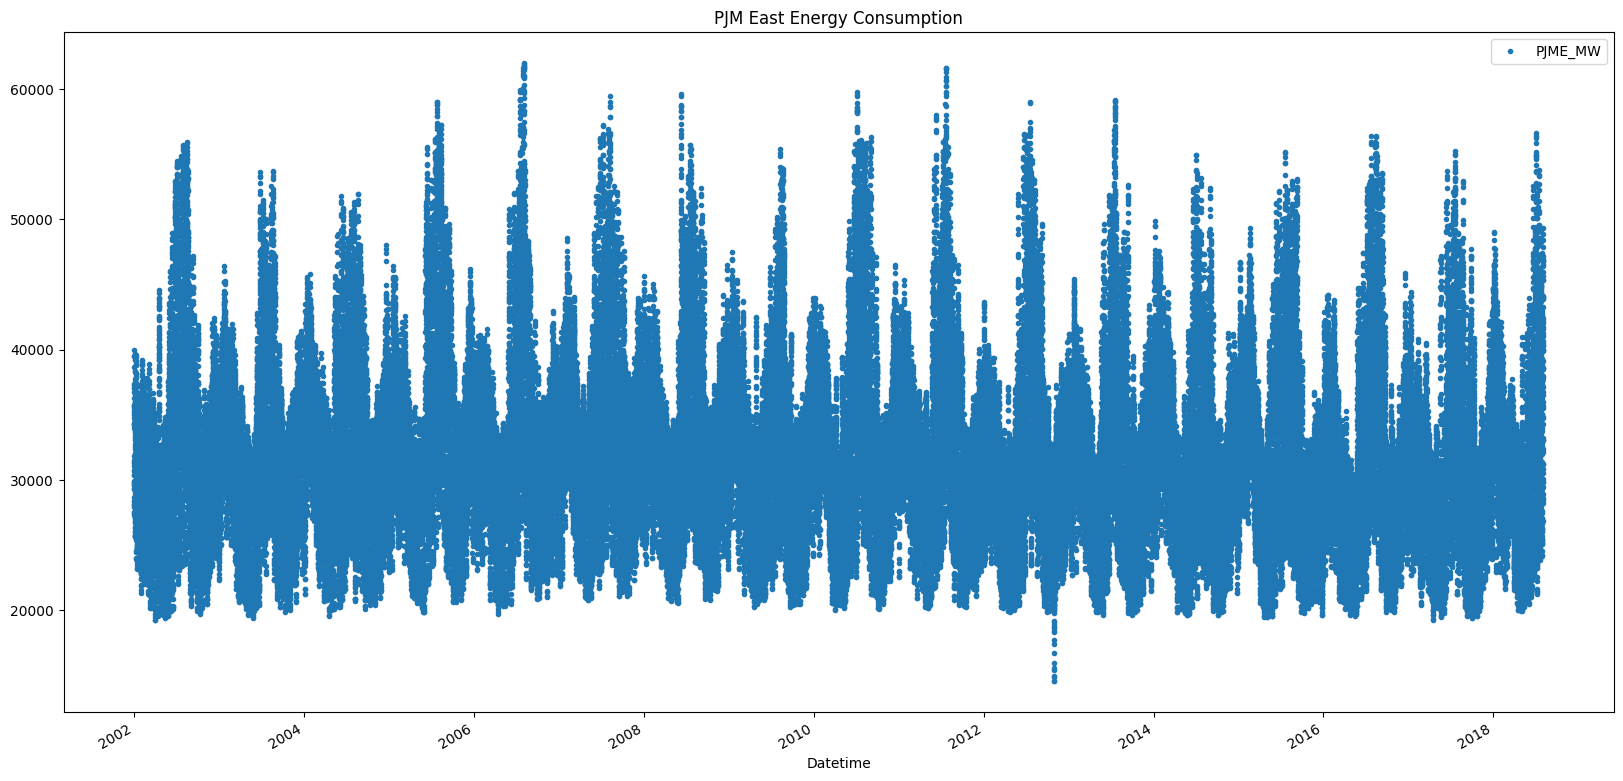

In [29]:
df = pd.read_csv("./assets/datasets/energy_consumption.csv", parse_dates=[0])
df.plot(x="Datetime", y="PJME_MW", style=".", figsize=(20, 10), title="PJM East Energy Consumption")
plt.show()

In [30]:
system_prompt = """You are a Data Science agent, which helps the user solve machine learning problems.

Respond with 1 of the following machine learning problems:
- Classification
- Regression
- Clustering
- Time series forecasting"""

prompt = """Choose the machine learning problem best suited for the following problem and dataset.

Problem description:
{problem_description}

Dataset:
Number of rows: {dataset_size}
Schema:
{dataset_schema}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=250,
    temperature=0.2,
)

problem_finder_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["problem_description", "dataset_size", "dataset_schema"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [31]:
system_prompt = """You are a Data Science agent, which helps the user solve machine learning problems.

You can solve machine learning problems for:
- Classification
- Regression
- Clustering
- Time series forecasting

You have access to the following Python libraries:
- pandas
- numpy
- scikit-learn
- fbprophet"""

prompt = """Given the following machine learning problem, respond with Python code.

Modeling problem: {modeling_problem}

Dataset:
Number of rows: {dataset_size}
Schema:
{dataset_schema}
First 10 rows of dataset:
{dataset_snippet}"""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4-32k',
    max_tokens=2000,
    temperature=0.2,
)

ml_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=prompt,
    prompt_variables=["modeling_problem", "dataset_size", "dataset_schema", "dataset_snippet"],
    output_type=OutputType.STRING,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [32]:
class MLCodeGeneration(BaseModel):
    problem_description: str = Field(description="The user problem")
    dataset_size: int = Field(description="Size of the dataset")
    dataset_schema: str = Field(description="Schema of the dataset")
    dataset_snippet: str = Field(description="Snippet of the dataset")

ml_workflow = Workflow(
    name="Generate Machine Learning Code",
    description="Allows you to generate ML code",
    inputs=MLCodeGeneration,
    output="code",
    steps=[WorkflowLLMStep(name="modeling_problem", agent=problem_finder_agent), WorkflowLLMStep(name="code", agent=ml_agent)],
)

In [33]:
info_str = StringIO()
df.info(buf=info_str)
dataset_schema = info_str.getvalue()

In [34]:
output = ml_workflow.invoke({
    "problem_description": "I want to forecast hourly energy use.",
    "dataset_size": len(df),
    "dataset_schema": dataset_schema,
    "dataset_snippet": str(df.head(10).to_markdown())
})

Use LLM: modeling_problem
Inputs: {'problem_description': 'I want to forecast hourly energy use.', 'dataset_size': 145366, 'dataset_schema': "<class 'pandas.core.frame.DataFrame'>\nRangeIndex: 145366 entries, 0 to 145365\nData columns (total 2 columns):\n #   Column    Non-Null Count   Dtype         \n---  ------    --------------   -----         \n 0   Datetime  145366 non-null  datetime64[ns]\n 1   PJME_MW   145366 non-null  float64       \ndtypes: datetime64[ns](1), float64(1)\nmemory usage: 2.2 MB\n"}
Prompt: Choose the machine learning problem best suited for the following problem and dataset.

Problem description:
I want to forecast hourly energy use.

Dataset:
Number of rows: 145366
Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64   

In [41]:
print(output.output)

similarities='Both jobs are in the field of electrical engineering and involve working with electrical systems and equipment. Both roles require technical knowledge in the design, installation, and maintenance of electrical systems. They also both involve safety testing and inspection activities.' differences='The Electrical Engineering Associate is more focused on the design, planning, and specification of electrical systems and equipment, as well as conducting engineering economic and cost analysis studies. This role may also involve code enforcement functions. The Electrical Mechanic, on the other hand, is more hands-on, performing skilled mechanical and electrical work in the installation and maintenance of high and low voltage electrical circuits and related equipment at various facilities and buildings. This role may involve working at heights, near hazardous materials, and in confined spaces. The salary ranges also differ, with the Electrical Engineering Associate having a wider

## Comparing Jobs

When comparing two job descriptions, one approach involves presenting both job postings to an LLM to identify similarities and differences. However, this method may not yield optimal results, as job descriptions often include non-essential information such as "equal employment opportunity" statements. To address this, we can deconstruct the problem by initially tasking an LLM to extract relevant data from each job description. In our case 2 instances as we are comparing 2 jobs. Subsequently, this condensed information can be inputted into a 3rd LLM, tasked with analyzing the extracted data to identify differences and similarities between the two jobs.

| Inputs |
|------|
| job 1 |
| job 2 |

<br/>

| LLM that extracts job data |
|------|
| `Inputs` job 1 |
| `Output` job title 1, job duties 1, salary 1 |

<br/>

| LLM that extracts job data |
|------|
| `Inputs` job 2 |
| `Output` job title 2, job duties 2, salary 2 |

<br/>

| LLM that compares 2 jobs |
|------|
| `Inputs` job title 1, job duties 1, salary 1, job title 2, job duties 2, salary 2 |
| `Output` differences, similarities |

<br/>

| Output |
|------|
| differences |
| similarities |

In [35]:
def get_job(path: str) -> str:
    with open(path, "r", encoding="utf-8") as file:
        content = file.read()
        return content

job1 = get_job("./assets/datasets/jobs/ELECTRICAL ENGINEERING ASSOCIATE 7525 093016 REV 100416.txt")
job2 = get_job("./assets/datasets/jobs/ELECTRICAL MECHANIC 3841 012017.txt")

In [36]:
system_prompt = "Take the following job and extract data about the job"

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4',
    max_tokens=500,
    temperature=0.2,
)

class Job(BaseModel):
    title: str = Field(description="The job title.")
    duties: str = Field(description="The duties of the job.")
    salary: list[str] = Field(description="A list of salary ranges. Format: 'min salary to max salary'.")

job_agent1 = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{job1}",
    prompt_variables=["job1"],
    output_type=OutputType.OBJECT,
    output_schema=Job,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

job_agent2 = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{job2}",
    prompt_variables=["job2"],
    output_type=OutputType.OBJECT,
    output_schema=Job,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

system_prompt = "Take the following 2 job descriptions and respond with the similarities and differences of the jobs."

task_prompt = """Compare the 2 given job descriptions:

Job 1:
Job title: {job1.title}
Job duties:
{job1.duties}
Salary:
{job1.salary}

Job 2:
Job title: {job2.title}
Job duties:
{job2.duties}
Salary:
{job2.salary}"""

class JobComparison(BaseModel):
    similarities: str = Field(description="The job similarities.")
    differences: str = Field(description="The job differences.")

job_comparison_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt=task_prompt,
    prompt_variables=["job1", "job2"],
    output_type=OutputType.OBJECT,
    output_schema=JobComparison,
    prompting_strategy=PromptingStrategy.SINGLE_COMPLETION,
    verbose=True,
)

In [37]:
class CompareJobs(BaseModel):
    job1: str = Field(description="The first job")
    job2: str = Field(description="The second job")

workflow = Workflow(
    name="Compare Jobs",
    description="Allows you to compare key information of 2 jobs",
    inputs=CompareJobs,
    output="job_comparison",
    steps=[
        WorkflowLLMStep(name="job1", agent=job_agent1),
        WorkflowLLMStep(name="job2", agent=job_agent2),
        WorkflowLLMStep(name="job_comparison", agent=job_comparison_agent),
    ],
)

In [38]:
output = workflow.invoke({"job1": job1, "job2": job2})

Use LLM: job1
Inputs: {'job1': 'ELECTRICAL ENGINEERING ASSOCIATE\nClass Code:       7525\nOpen Date:  09-30-16\nREVISED: 10-04-16\n (Exam Open to All, including Current City Employees)\nANNUAL SALARY \n\n$66,231 to $94,252; $74,082 to $105,444; $82,497 to $117,346; and $89,638 to $127,556\nThe salary in the Department of Water and Power is $77,360 to $96,110; $91,934 to $114,213; $99,722 to $123,881; and $107,156 to \n$133,130\n\nNOTES:\n\n1. Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions.\n2. For information regarding reciprocity between City of Los Angeles departments and LADWP, go to: http://per.lacity.org/Reciprocity_CityDepts_and_DWP.pdf.\n3. The current salary range is subject to change. You may confirm the starting salary with the hiring department before accepting a job offer.\n\nDUTIES\n\nAn Electrical Engineering Associate performs professional electrical engineering work in the preparation of designs, plans, specificati

In [39]:
print(output.output.similarities)

Both jobs are in the field of electrical engineering and involve working with electrical systems and equipment. Both roles require technical knowledge in the design, installation, and maintenance of electrical systems. They also both involve safety testing and inspection activities.


In [40]:
print(output.output.differences)

The Electrical Engineering Associate is more focused on the design, planning, and specification of electrical systems and equipment, as well as conducting engineering economic and cost analysis studies. This role may also involve code enforcement functions. The Electrical Mechanic, on the other hand, is more hands-on, performing skilled mechanical and electrical work in the installation and maintenance of high and low voltage electrical circuits and related equipment at various facilities and buildings. This role may involve working at heights, near hazardous materials, and in confined spaces. The salary ranges also differ, with the Electrical Engineering Associate having a wider range and potentially higher salary.


## Transforming Unstructured Data into Structured Formats

An excellent application of LLMs involves organizing unstructured data, such as text documents. Take, for instance, a collection of job descriptions. While there are various methods to tackle this task, like coding a parser or using optical character recognition, we opt to leverage an LLM for the job. Initially, we define the specific information we wish to extract from the job postings, such as the job title, salary, application instructions, and more. The LLM then looks at each job description and extracts the details for us. Subsequently, we can effortlessly store this dataset as a CSV file for further analysis and use.

In [ ]:
path = Path("./assets/datasets/jobs")
filenames = [file.name for file in path.iterdir() if file.is_file()]
jobs = []
for filename in filenames:
    file_path = path / filename
    with open(file_path, "r", encoding="utf-8", errors="replace") as file:
        content = file.read()
        jobs.append(content)

In [ ]:
system_prompt = """Take the following job and extract data about the job.

Respond with the job information:
- job title: title of the job.
- job class no: class number as an integer.
- job duties: duties of the job.
- open date: when the position was created. Use DD-MM-YYYY.
- salary: the salary ranges.
- deadline: when the application deadline is. Use DD-MM-YYYY.
- application form: online or email or fax.
- where to apply: url or location."""

llm = OpenAILanguageModel(
    proxy_client=proxy_client,
    model='gpt-4-32k',
    max_tokens=1000,
    temperature=0.2,
)

class Salary(BaseModel):
    description: str = Field(description="The description of the level")
    min_salary: float = Field(description="The minimum salary for this position or level")
    max_salary: float = Field(description="The maximum salary for this position or level")

class Job(BaseModel):
    job_title: str = Field(description="The job title.")
    job_class_no: int = Field(description="The job class number as an integer.")
    job_duties: str = Field(description="The duties of the job.")
    open_date: str = Field(description="When the position was opened. Format: DD-MM-YYYY.")
    salary: list[Salary] = Field(description="A list of salary ranges. Format: 'min salary to max salary'.")
    deadline: str = Field(description="The application deadline. Format: DD-MM-YYYY")
    application_form: str = Field(description="The form of the application (e.g. online, fax, email).")
    where_to_apply: str = Field(description="The url to apply at or location to send the fax or email address.")

job_data_agent = Agent.create(
    llm=llm,
    system_prompt=system_prompt,
    prompt="{job}",
    prompt_variables=["job"],
    output_type=OutputType.STRUCT,
    output_schema=Job,
    prompting_strategy=PromptingStrategy.CHAIN_OF_THOUGHT,
    verbose=True,
)

In [ ]:
def extract_jobs(jobs: list[str]) -> pd.DataFrame:
    data = []
    for job in jobs:
        output = job_data_agent.invoke({"job": job})
        data.append(output.final_answer)
        job_data_agent.chat.reset()
    return pd.DataFrame(data)

In [ ]:
df_jobs = extract_jobs(jobs)

In [ ]:
df_jobs.head()

In [ ]:
df_jobs.to_csv("./assets/datasets/jobs.csv", index=False)